In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Activation, Dense, Conv2D, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Input, UpSampling2D
import time
import matplotlib.pyplot as plt

from IPython import display

#tf.config.run_functions_eagerly(True)

BATCH_SIZE = 8

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
dir_name = '/kaggle/input/gan-getting-started/monet_jpg'

images_dataset = tf.keras.utils.image_dataset_from_directory(dir_name, batch_size=None, labels=None)
images_dataset = images_dataset.map(lambda image: tf.image.resize(image, (256, 256)) / 255.0)
print(images_dataset)


Found 300 files belonging to 1 classes.
<_MapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>


In [3]:
train_dataset = images_dataset.shuffle(buffer_size=300).batch(BATCH_SIZE)

In [4]:
def build_dc_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(16*16*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 128)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.UpSampling2D())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    #assert model.output_shape == (None, 256, 256, 3)

    return model


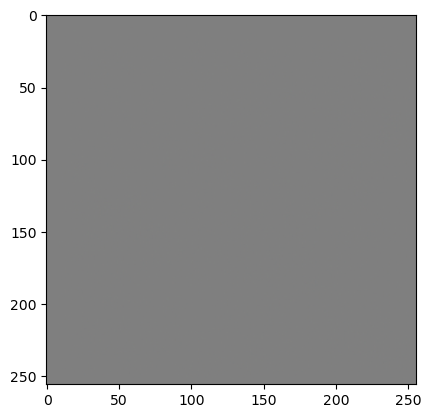

In [5]:
#generator = make_generator_model()
generator = build_dc_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = (generated_image + 1) / 2.0
generated_image = np.clip(generated_image.numpy().squeeze(), 0, 1)
#plt.imshow(generated_image[0, :, :, 3], cmap='grey')
plt.imshow(generated_image)
plt.show()
generated_image = np.expand_dims(generated_image, axis=0)

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [7]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.01761176]], shape=(1, 1), dtype=float32)


In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_loss_sum = 0
    disc_loss_sum = 0
    num_batches = 0

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_sum += gen_loss
      disc_loss_sum += disc_loss
      num_batches += 1

    gen_loss_avg = gen_loss_sum / num_batches
    disc_loss_avg = disc_loss_sum / num_batches

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    #if (epoch + 1) % 100 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    print(f"Loss:\n")
    print(f"Epoch {epoch + 1}, Gen loss: {gen_loss_avg}, Disc loss: {disc_loss_avg}")
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [13]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    gen_loss = None
    disc_loss = None
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.axis('off')
      plt.imshow(predictions[i])

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

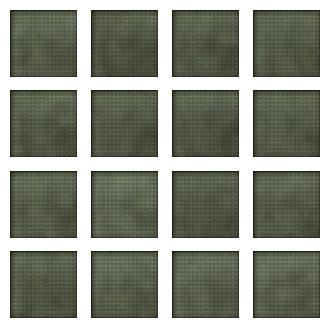

In [16]:
np.shape(train_dataset)
train(train_dataset, EPOCHS)

In [17]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [18]:
for x in range(10000):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    filename = f"{x}.jpg"
    tf.keras.utils.save_img(filename, generated_image[0,:,:], file_format="jpeg")

In [19]:
import zipfile
import os

# Get the current directory
current_directory = os.getcwd()

# Get all the jpg images in the current directory
jpg_images = [image for image in os.listdir(current_directory) if image.endswith(".jpg")]

# Create a zip file
zip_file = zipfile.ZipFile("images.zip", "w")

# Add all the jpg images to the zip file
for jpg_image in jpg_images:
  zip_file.write(jpg_image)

# Close the zip file
zip_file.close()